<a href="https://colab.research.google.com/github/artemk1337/DCGAN-label_embedding-MNIST/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Flatten,
                                     MaxPool2D, GlobalAvgPool2D, LeakyReLU, 
                                     Reshape, Input, Embedding, multiply, 
                                     BatchNormalization, GlobalMaxPool2D)
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np
from tqdm import tqdm

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [4]:
def normalize_img(image):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.


X_train = normalize_img(X_train)
X_test = normalize_img(X_test)

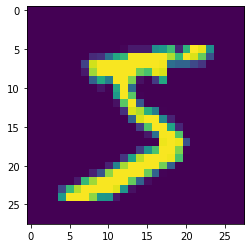

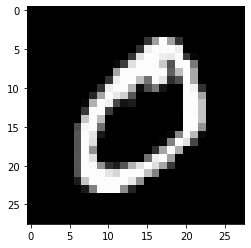

In [5]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(X_train[1], cmap='gray')
plt.show()

In [18]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid'))
    return model


def create_embedding_g(output_dim):
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(10, output_dim)(label)
    label_embedding = Flatten()(label_embedding)
    return label, label_embedding


def build_generator_embedding(img_shape):
    z = Input(shape=(z_dim,))
    generator = build_generator(img_shape, z_dim)
    # generator.summary()
    label, label_embedding = create_embedding_g(z_dim)
    img = generator(multiply([z, label_embedding]))
    generator = Model([z, label], img)
    return generator

In [19]:
def build_discriminator(img_shape, header=True):
    input = Input(shape=(img_shape))
    model = Conv2D(128, 3, strides=2, padding='same')(input)
    model = LeakyReLU(alpha=0.2)(model)
    model = Conv2D(128, 3, strides=2, padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Conv2D(256, 3, strides=1, padding='same')(model)
    model = GlobalMaxPool2D()(model)
    if header is True:
        model = Dense(1, activation='sigmoid')(model)
    output = model
    model = Model(input, output)
    return input, output, model


def create_embedding_d(output_shape):
    dim = lambda x, y, z: x*y*z
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(10, dim(*output_shape))(label)
    label_embedding = Reshape(output_shape)(label_embedding)
    model = Model(label, label_embedding)
    return label, label_embedding, model


def build_discriminator_embedding(img_shape):
    img_d = Input(shape=(img_shape))
    input_label, output_label, model_label = create_embedding_d(img_shape)
    # model_label.summary()

    input_discriminator, output_discriminator, model_discriminator = build_discriminator(img_shape, True)
    # model_discriminator.summary()

    multiplied = multiply([img_d, output_label])
    final_output = model_discriminator(multiplied)
    model = Model([img_d, input_label], final_output)
    return model

In [20]:
def build_gan(generator, discriminator, z_dim):
    discriminator.trainable = False
    gan_input_dim = Input(shape=(z_dim,))
    gan_input_label = Input(shape=(1,), dtype='int32')
    gan_input = [gan_input_dim, gan_input_label]
    x = generator(gan_input)
    gan_output = discriminator([x, gan_input_label])
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan


def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [21]:
generator = build_generator_embedding(img_shape)
# generator.summary()

discriminator = build_discriminator_embedding(img_shape)
# discriminator.summary()

optimizer = Adam(lr=0.0002)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

optimizer = Adam(lr=0.0002)
gan = build_gan(generator, discriminator, z_dim)
gan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

100%|██████████| 468/468 [00:29<00:00, 16.13it/s]


epoch = 1/100, d_loss=0.250, g_loss=2.988                                                                                                     


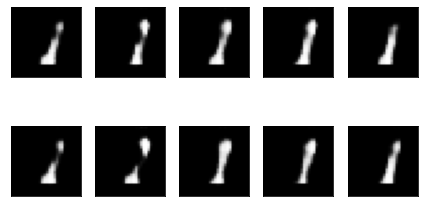

100%|██████████| 468/468 [00:26<00:00, 17.81it/s]


epoch = 2/100, d_loss=0.270, g_loss=2.857                                                                                                     


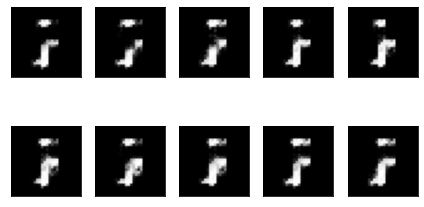

100%|██████████| 468/468 [00:26<00:00, 17.85it/s]


epoch = 3/100, d_loss=0.245, g_loss=3.175                                                                                                     


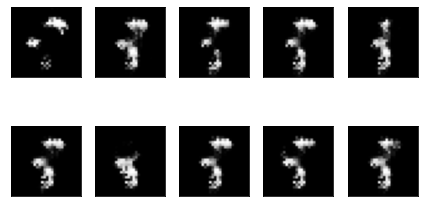

100%|██████████| 468/468 [00:26<00:00, 17.94it/s]


epoch = 4/100, d_loss=0.392, g_loss=2.247                                                                                                     


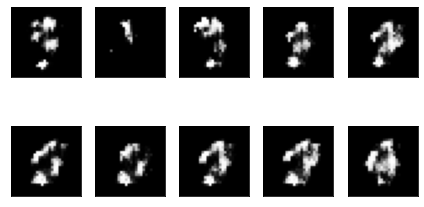

100%|██████████| 468/468 [00:25<00:00, 18.02it/s]


epoch = 5/100, d_loss=0.641, g_loss=0.958                                                                                                     


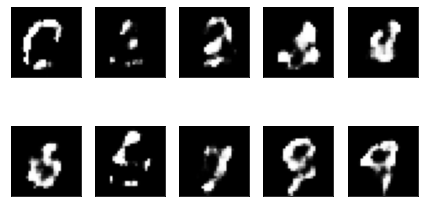

100%|██████████| 468/468 [00:25<00:00, 18.04it/s]


epoch = 6/100, d_loss=0.674, g_loss=0.797                                                                                                     


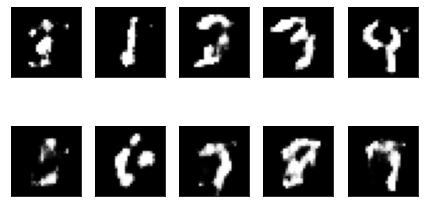

100%|██████████| 468/468 [00:26<00:00, 17.48it/s]


epoch = 7/100, d_loss=0.676, g_loss=0.790                                                                                                     


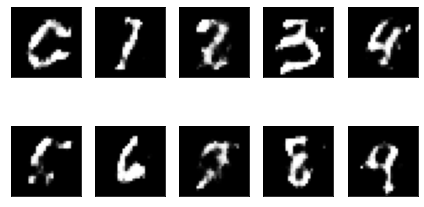

100%|██████████| 468/468 [00:27<00:00, 17.28it/s]


epoch = 8/100, d_loss=0.682, g_loss=0.789                                                                                                     


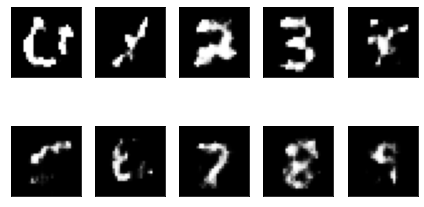

100%|██████████| 468/468 [00:26<00:00, 17.46it/s]


epoch = 9/100, d_loss=0.695, g_loss=0.776                                                                                                     


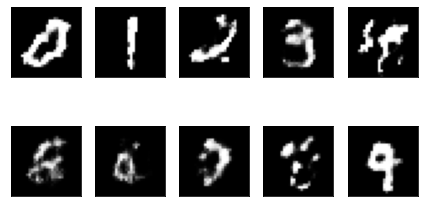

100%|██████████| 468/468 [00:26<00:00, 17.69it/s]


epoch = 10/100, d_loss=0.679, g_loss=0.773                                                                                                     


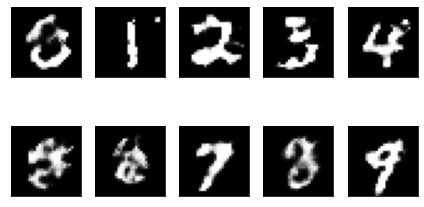

100%|██████████| 468/468 [00:26<00:00, 17.51it/s]


epoch = 11/100, d_loss=0.675, g_loss=0.688                                                                                                     


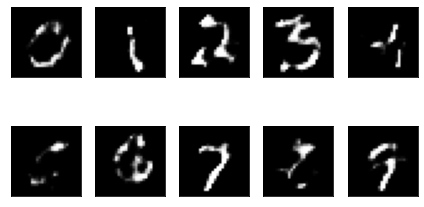

100%|██████████| 468/468 [00:26<00:00, 17.59it/s]


epoch = 12/100, d_loss=0.686, g_loss=0.739                                                                                                     


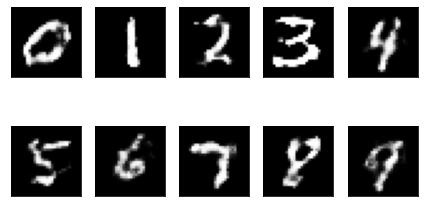

100%|██████████| 468/468 [00:26<00:00, 17.64it/s]


epoch = 13/100, d_loss=0.680, g_loss=0.736                                                                                                     


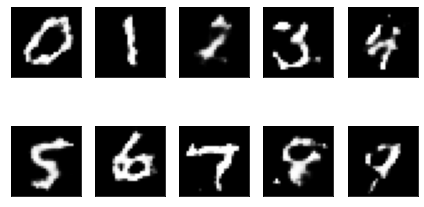

100%|██████████| 468/468 [00:26<00:00, 17.62it/s]


epoch = 14/100, d_loss=0.679, g_loss=0.686                                                                                                     


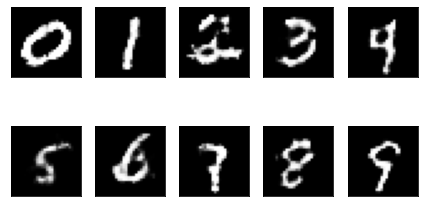

100%|██████████| 468/468 [00:26<00:00, 17.37it/s]


epoch = 15/100, d_loss=0.680, g_loss=0.714                                                                                                     


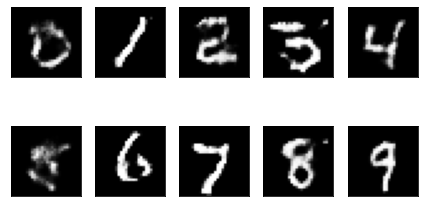

100%|██████████| 468/468 [00:27<00:00, 16.75it/s]


epoch = 16/100, d_loss=0.682, g_loss=0.742                                                                                                     


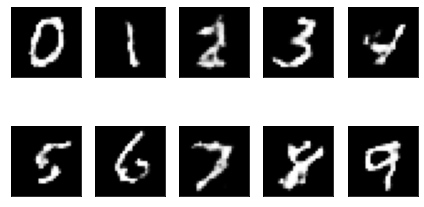

100%|██████████| 468/468 [00:27<00:00, 17.27it/s]


epoch = 17/100, d_loss=0.690, g_loss=0.794                                                                                                     


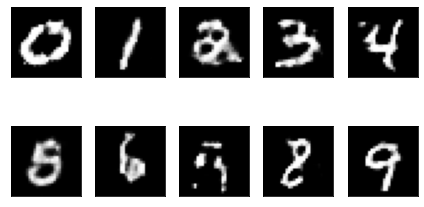

100%|██████████| 468/468 [00:27<00:00, 17.19it/s]


epoch = 18/100, d_loss=0.687, g_loss=0.787                                                                                                     


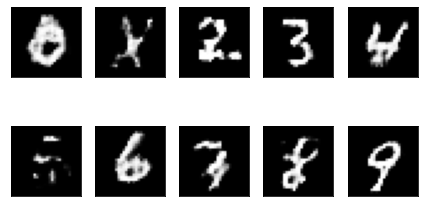

100%|██████████| 468/468 [00:28<00:00, 16.50it/s]


epoch = 19/100, d_loss=0.678, g_loss=0.763                                                                                                     


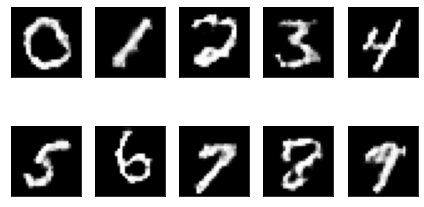

100%|██████████| 468/468 [00:27<00:00, 17.17it/s]


epoch = 20/100, d_loss=0.691, g_loss=0.699                                                                                                     


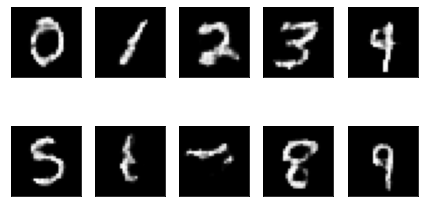

100%|██████████| 468/468 [00:26<00:00, 17.88it/s]


epoch = 21/100, d_loss=0.695, g_loss=0.725                                                                                                     


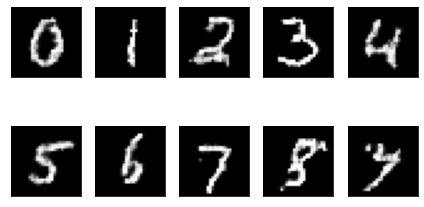

100%|██████████| 468/468 [00:26<00:00, 17.68it/s]


epoch = 22/100, d_loss=0.696, g_loss=0.770                                                                                                     


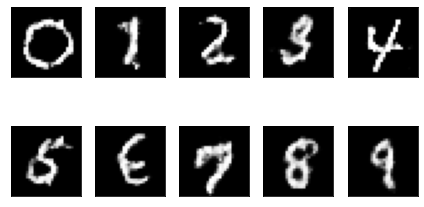

100%|██████████| 468/468 [00:26<00:00, 17.57it/s]


epoch = 23/100, d_loss=0.678, g_loss=0.788                                                                                                     


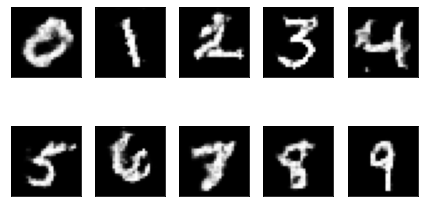

100%|██████████| 468/468 [00:26<00:00, 17.94it/s]


epoch = 24/100, d_loss=0.697, g_loss=0.691                                                                                                     


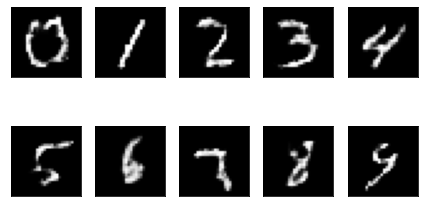

100%|██████████| 468/468 [00:26<00:00, 17.84it/s]


epoch = 25/100, d_loss=0.724, g_loss=0.701                                                                                                     


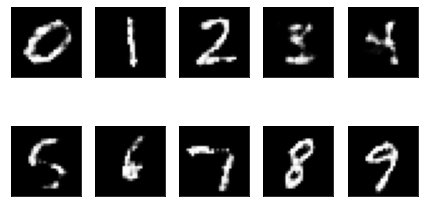

100%|██████████| 468/468 [00:25<00:00, 18.02it/s]


epoch = 26/100, d_loss=0.665, g_loss=0.707                                                                                                     


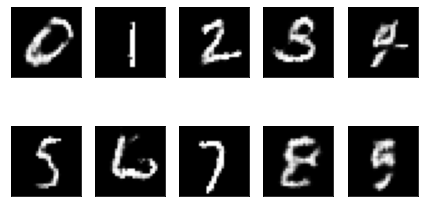

100%|██████████| 468/468 [00:26<00:00, 17.93it/s]


epoch = 27/100, d_loss=0.680, g_loss=0.788                                                                                                     


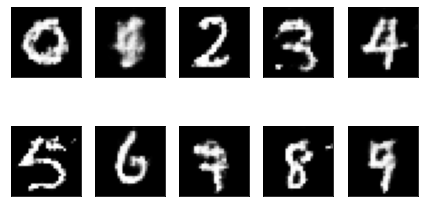

100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


epoch = 28/100, d_loss=0.714, g_loss=0.764                                                                                                     


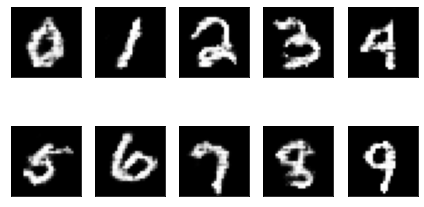

100%|██████████| 468/468 [00:25<00:00, 18.00it/s]


epoch = 29/100, d_loss=0.685, g_loss=0.759                                                                                                     


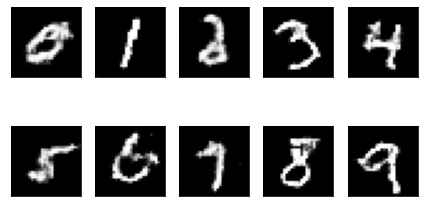

100%|██████████| 468/468 [00:26<00:00, 17.55it/s]


epoch = 30/100, d_loss=0.691, g_loss=0.783                                                                                                     


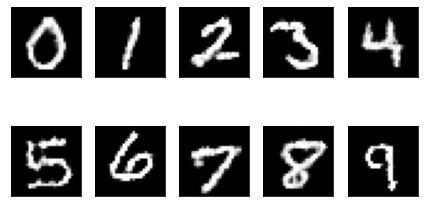

100%|██████████| 468/468 [00:26<00:00, 17.89it/s]


epoch = 31/100, d_loss=0.732, g_loss=0.712                                                                                                     


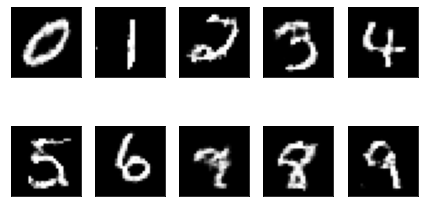

100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


epoch = 32/100, d_loss=0.657, g_loss=0.739                                                                                                     


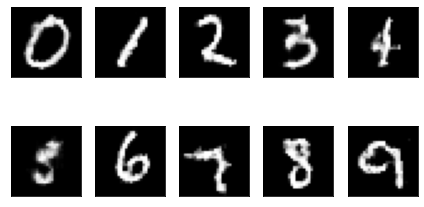

100%|██████████| 468/468 [00:26<00:00, 17.79it/s]


epoch = 33/100, d_loss=0.688, g_loss=0.778                                                                                                     


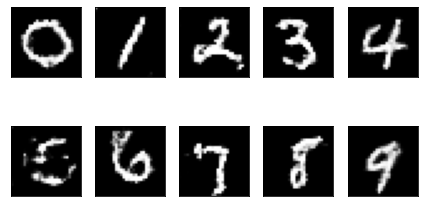

100%|██████████| 468/468 [00:26<00:00, 17.86it/s]


epoch = 34/100, d_loss=0.679, g_loss=0.843                                                                                                     


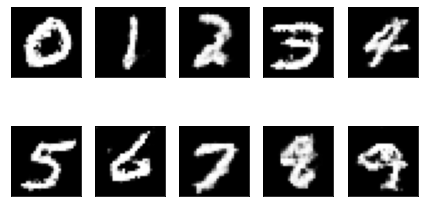

100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


epoch = 35/100, d_loss=0.700, g_loss=0.740                                                                                                     


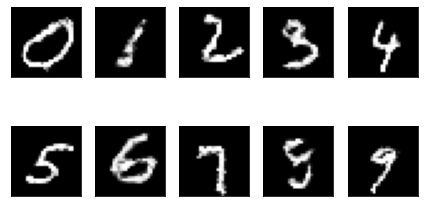

100%|██████████| 468/468 [00:26<00:00, 17.88it/s]


epoch = 36/100, d_loss=0.677, g_loss=0.772                                                                                                     


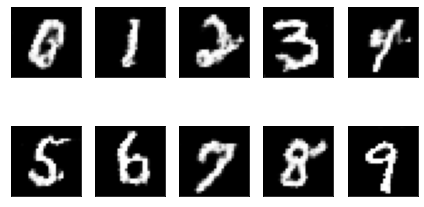

100%|██████████| 468/468 [00:27<00:00, 17.10it/s]


epoch = 37/100, d_loss=0.684, g_loss=0.834                                                                                                     


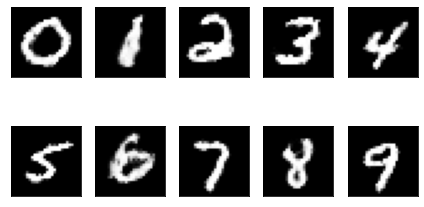

100%|██████████| 468/468 [00:27<00:00, 17.05it/s]


epoch = 38/100, d_loss=0.698, g_loss=0.749                                                                                                     


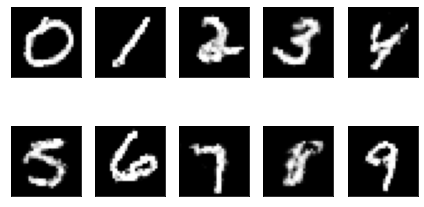

100%|██████████| 468/468 [00:26<00:00, 17.56it/s]


epoch = 39/100, d_loss=0.655, g_loss=0.728                                                                                                     


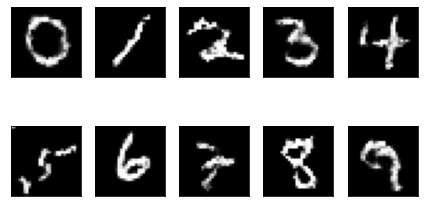

100%|██████████| 468/468 [00:25<00:00, 18.01it/s]


epoch = 40/100, d_loss=0.696, g_loss=0.885                                                                                                     


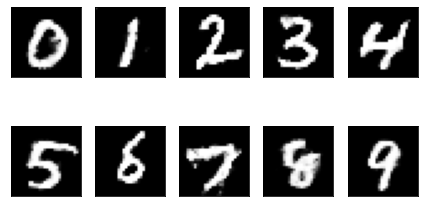

100%|██████████| 468/468 [00:25<00:00, 18.01it/s]


epoch = 41/100, d_loss=0.676, g_loss=0.816                                                                                                     


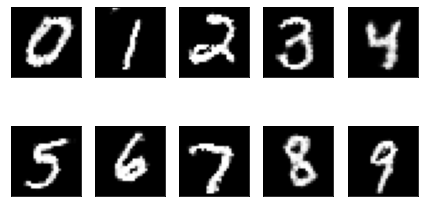

100%|██████████| 468/468 [00:26<00:00, 17.60it/s]


epoch = 42/100, d_loss=0.646, g_loss=0.729                                                                                                     


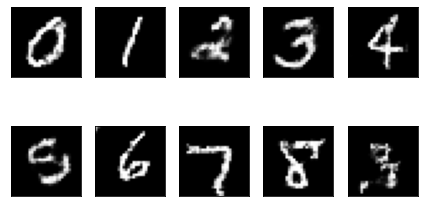

100%|██████████| 468/468 [00:26<00:00, 17.72it/s]


epoch = 43/100, d_loss=0.694, g_loss=0.811                                                                                                     


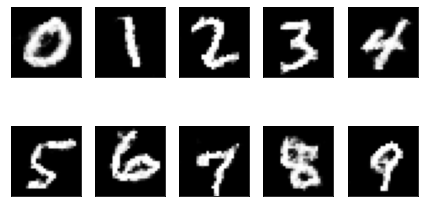

100%|██████████| 468/468 [00:26<00:00, 17.45it/s]


epoch = 44/100, d_loss=0.661, g_loss=0.884                                                                                                     


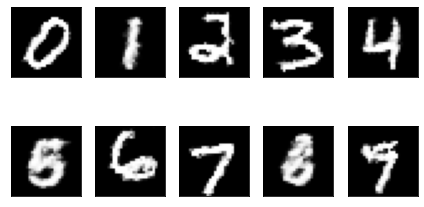

100%|██████████| 468/468 [00:26<00:00, 17.55it/s]


epoch = 45/100, d_loss=0.682, g_loss=0.792                                                                                                     


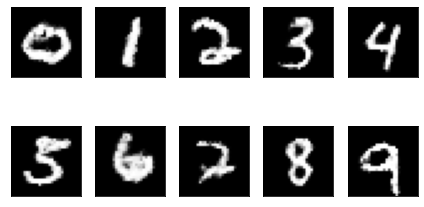

100%|██████████| 468/468 [00:26<00:00, 17.67it/s]


epoch = 46/100, d_loss=0.683, g_loss=0.727                                                                                                     


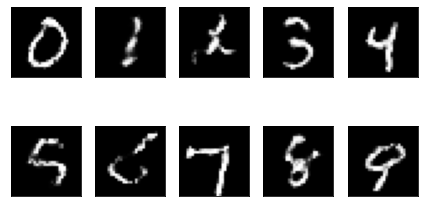

100%|██████████| 468/468 [00:26<00:00, 17.54it/s]


epoch = 47/100, d_loss=0.654, g_loss=0.782                                                                                                     


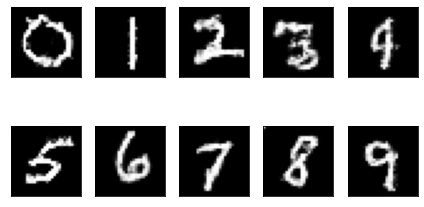

100%|██████████| 468/468 [00:26<00:00, 17.62it/s]


epoch = 48/100, d_loss=0.636, g_loss=0.774                                                                                                     


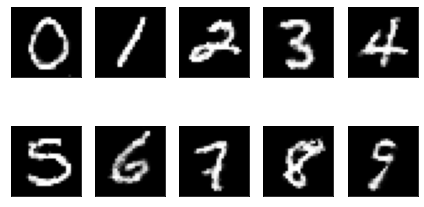

100%|██████████| 468/468 [00:26<00:00, 17.73it/s]


epoch = 49/100, d_loss=0.650, g_loss=0.736                                                                                                     


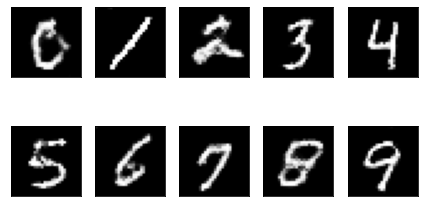

100%|██████████| 468/468 [00:26<00:00, 17.36it/s]


epoch = 50/100, d_loss=0.645, g_loss=0.762                                                                                                     


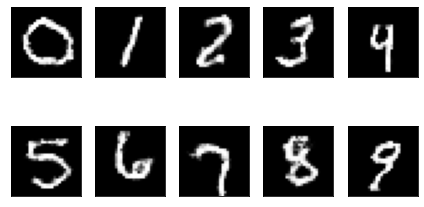

100%|██████████| 468/468 [00:26<00:00, 17.38it/s]


epoch = 51/100, d_loss=0.648, g_loss=0.779                                                                                                     


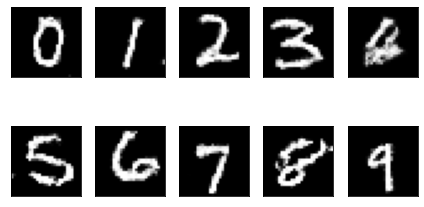

100%|██████████| 468/468 [00:27<00:00, 17.33it/s]


epoch = 52/100, d_loss=0.676, g_loss=0.755                                                                                                     


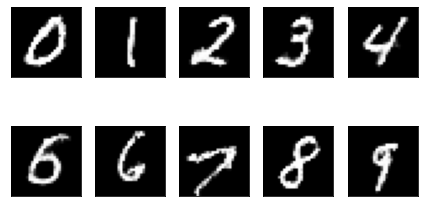

100%|██████████| 468/468 [00:27<00:00, 17.05it/s]


epoch = 53/100, d_loss=0.698, g_loss=0.709                                                                                                     


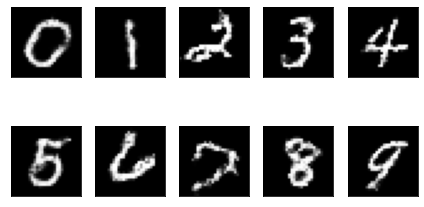

100%|██████████| 468/468 [00:27<00:00, 17.20it/s]


epoch = 54/100, d_loss=0.665, g_loss=0.710                                                                                                     


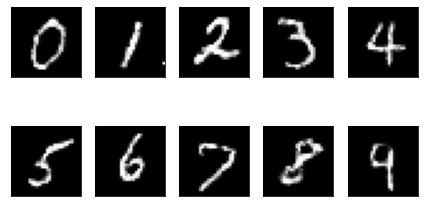

100%|██████████| 468/468 [00:26<00:00, 17.42it/s]


epoch = 55/100, d_loss=0.732, g_loss=0.736                                                                                                     


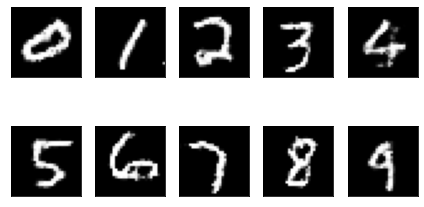

100%|██████████| 468/468 [00:26<00:00, 17.83it/s]


epoch = 56/100, d_loss=0.693, g_loss=0.848                                                                                                     


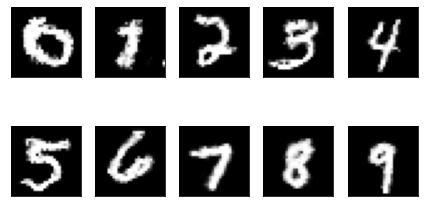

100%|██████████| 468/468 [00:26<00:00, 17.82it/s]


epoch = 57/100, d_loss=0.665, g_loss=0.841                                                                                                     


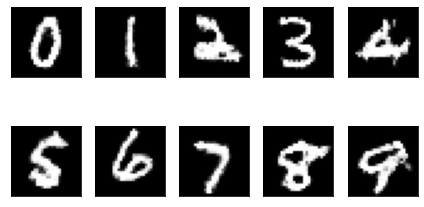

100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


epoch = 58/100, d_loss=0.672, g_loss=0.833                                                                                                     


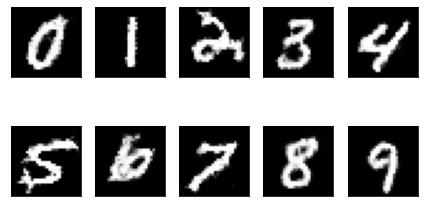

100%|██████████| 468/468 [00:26<00:00, 17.93it/s]


epoch = 59/100, d_loss=0.660, g_loss=0.767                                                                                                     


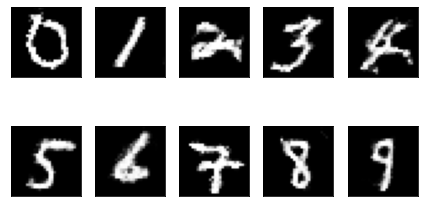

100%|██████████| 468/468 [00:26<00:00, 17.82it/s]


epoch = 60/100, d_loss=0.655, g_loss=0.739                                                                                                     


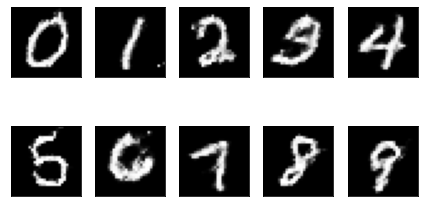

100%|██████████| 468/468 [00:26<00:00, 17.67it/s]


epoch = 61/100, d_loss=0.678, g_loss=0.843                                                                                                     


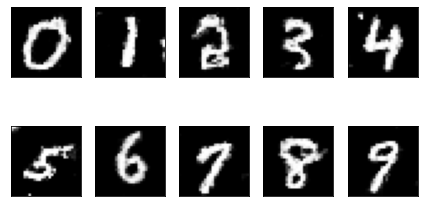

100%|██████████| 468/468 [00:25<00:00, 18.10it/s]


epoch = 62/100, d_loss=0.674, g_loss=0.840                                                                                                     


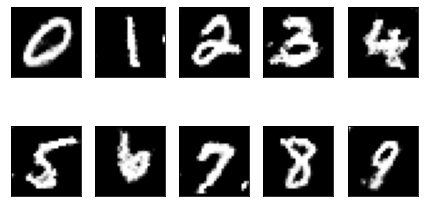

100%|██████████| 468/468 [00:25<00:00, 18.08it/s]


epoch = 63/100, d_loss=0.638, g_loss=0.750                                                                                                     


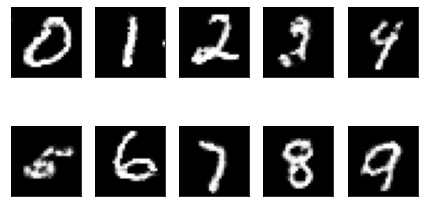

100%|██████████| 468/468 [00:25<00:00, 18.04it/s]


epoch = 64/100, d_loss=0.642, g_loss=0.746                                                                                                     


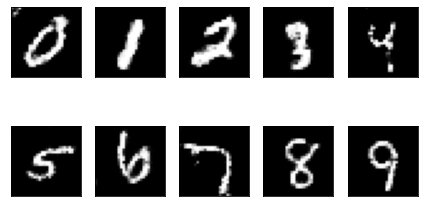

100%|██████████| 468/468 [00:26<00:00, 17.44it/s]


epoch = 65/100, d_loss=0.619, g_loss=0.761                                                                                                     


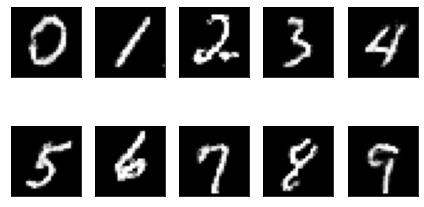

100%|██████████| 468/468 [00:26<00:00, 17.46it/s]


epoch = 66/100, d_loss=0.637, g_loss=0.767                                                                                                     


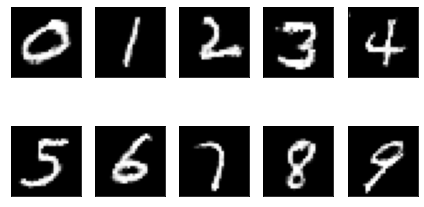

100%|██████████| 468/468 [00:26<00:00, 17.52it/s]


epoch = 67/100, d_loss=0.698, g_loss=0.743                                                                                                     


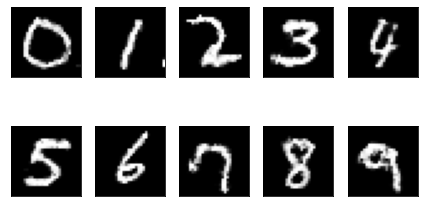

100%|██████████| 468/468 [00:26<00:00, 17.69it/s]


epoch = 68/100, d_loss=0.655, g_loss=0.756                                                                                                     


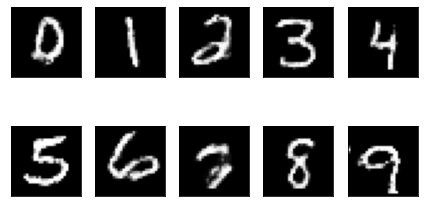

100%|██████████| 468/468 [00:27<00:00, 17.23it/s]


epoch = 69/100, d_loss=0.685, g_loss=0.746                                                                                                     


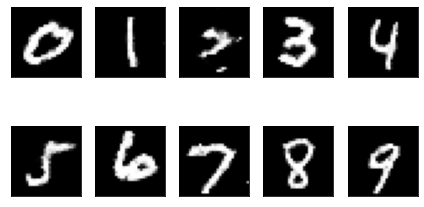

100%|██████████| 468/468 [00:27<00:00, 17.06it/s]


epoch = 70/100, d_loss=0.702, g_loss=0.768                                                                                                     


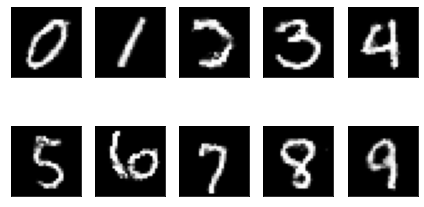

100%|██████████| 468/468 [00:26<00:00, 17.51it/s]


epoch = 71/100, d_loss=0.670, g_loss=0.742                                                                                                     


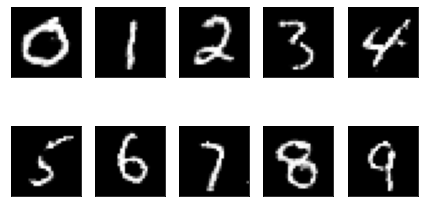

100%|██████████| 468/468 [00:25<00:00, 18.04it/s]


epoch = 72/100, d_loss=0.689, g_loss=0.727                                                                                                     


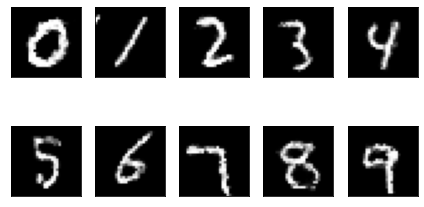

100%|██████████| 468/468 [00:26<00:00, 17.98it/s]


epoch = 73/100, d_loss=0.662, g_loss=0.755                                                                                                     


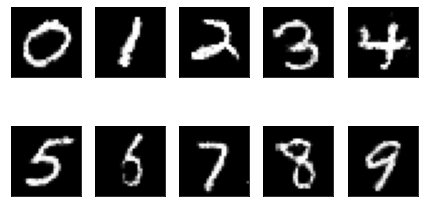

100%|██████████| 468/468 [00:25<00:00, 18.14it/s]


epoch = 74/100, d_loss=0.662, g_loss=0.704                                                                                                     


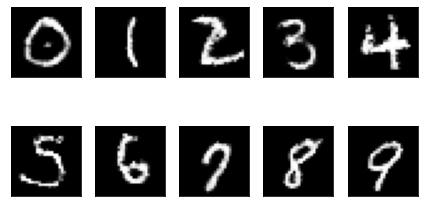

100%|██████████| 468/468 [00:25<00:00, 18.01it/s]


epoch = 75/100, d_loss=0.690, g_loss=0.749                                                                                                     


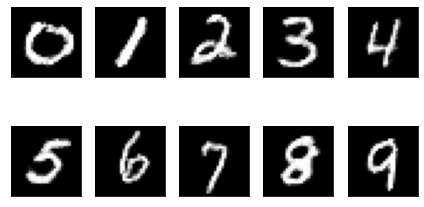

100%|██████████| 468/468 [00:26<00:00, 17.78it/s]


epoch = 76/100, d_loss=0.670, g_loss=0.768                                                                                                     


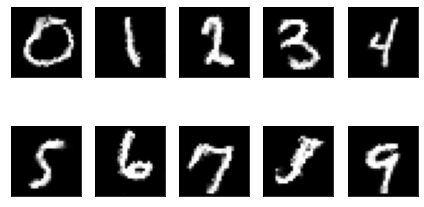

100%|██████████| 468/468 [00:27<00:00, 17.14it/s]


epoch = 77/100, d_loss=0.695, g_loss=0.795                                                                                                     


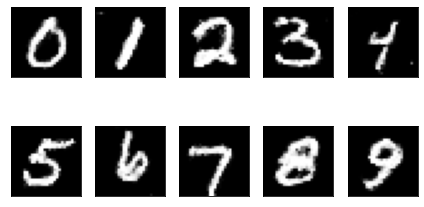

100%|██████████| 468/468 [00:26<00:00, 17.56it/s]


epoch = 78/100, d_loss=0.675, g_loss=0.753                                                                                                     


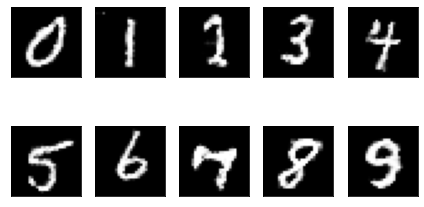

100%|██████████| 468/468 [00:26<00:00, 17.60it/s]


epoch = 79/100, d_loss=0.687, g_loss=0.763                                                                                                     


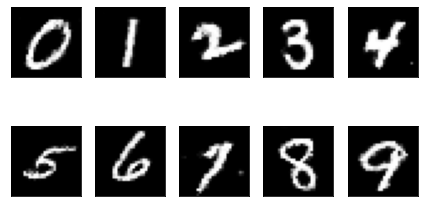

100%|██████████| 468/468 [00:26<00:00, 17.62it/s]


epoch = 80/100, d_loss=0.695, g_loss=0.782                                                                                                     


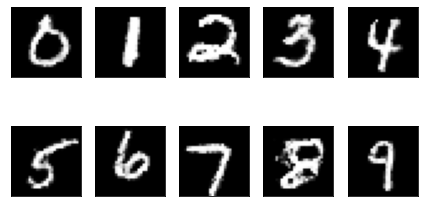

100%|██████████| 468/468 [00:26<00:00, 17.53it/s]


epoch = 81/100, d_loss=0.680, g_loss=0.798                                                                                                     


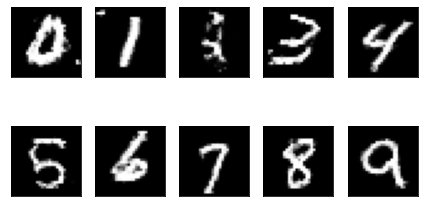

100%|██████████| 468/468 [00:26<00:00, 17.70it/s]


epoch = 82/100, d_loss=0.711, g_loss=0.748                                                                                                     


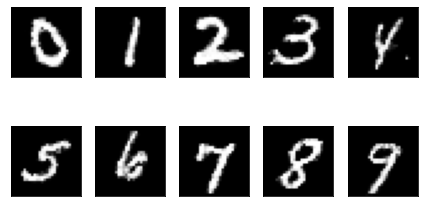

100%|██████████| 468/468 [00:26<00:00, 17.47it/s]


epoch = 83/100, d_loss=0.697, g_loss=0.780                                                                                                     


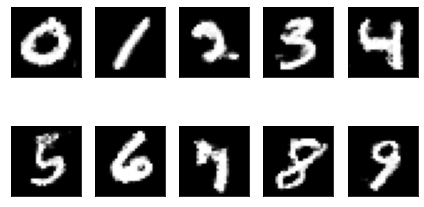

100%|██████████| 468/468 [00:26<00:00, 17.46it/s]


epoch = 84/100, d_loss=0.699, g_loss=0.755                                                                                                     


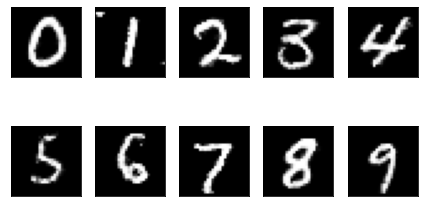

100%|██████████| 468/468 [00:26<00:00, 17.56it/s]


epoch = 85/100, d_loss=0.676, g_loss=0.767                                                                                                     


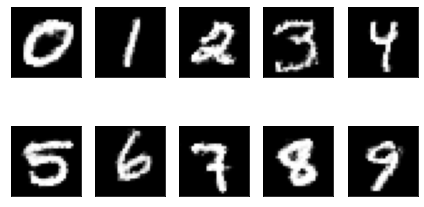

100%|██████████| 468/468 [00:26<00:00, 17.83it/s]


epoch = 86/100, d_loss=0.688, g_loss=0.750                                                                                                     


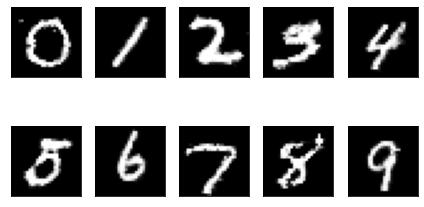

100%|██████████| 468/468 [00:26<00:00, 17.75it/s]


epoch = 87/100, d_loss=0.674, g_loss=0.790                                                                                                     


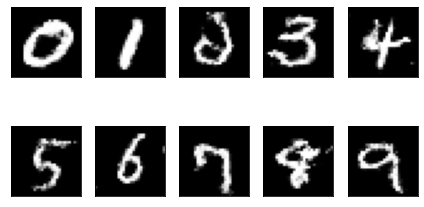

100%|██████████| 468/468 [00:27<00:00, 17.33it/s]


epoch = 88/100, d_loss=0.682, g_loss=0.721                                                                                                     


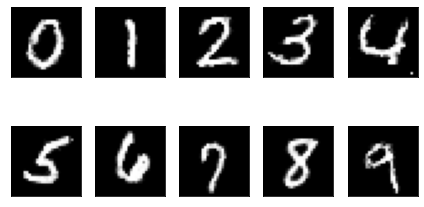

100%|██████████| 468/468 [00:26<00:00, 17.67it/s]


epoch = 89/100, d_loss=0.685, g_loss=0.789                                                                                                     


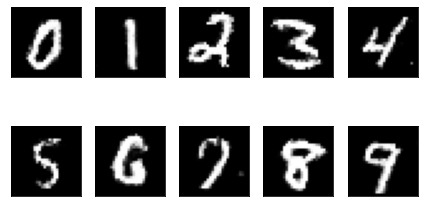

100%|██████████| 468/468 [00:25<00:00, 18.17it/s]


epoch = 90/100, d_loss=0.684, g_loss=0.747                                                                                                     


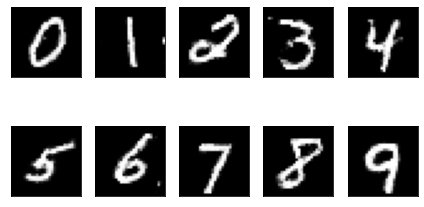

100%|██████████| 468/468 [00:25<00:00, 18.24it/s]


epoch = 91/100, d_loss=0.672, g_loss=0.773                                                                                                     


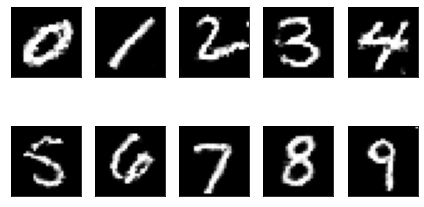

100%|██████████| 468/468 [00:25<00:00, 18.35it/s]


epoch = 92/100, d_loss=0.669, g_loss=0.772                                                                                                     


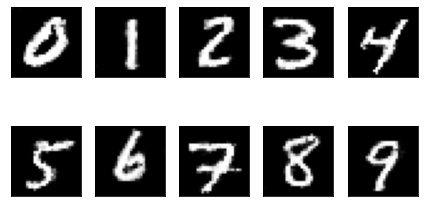

100%|██████████| 468/468 [00:25<00:00, 18.36it/s]


epoch = 93/100, d_loss=0.661, g_loss=0.744                                                                                                     


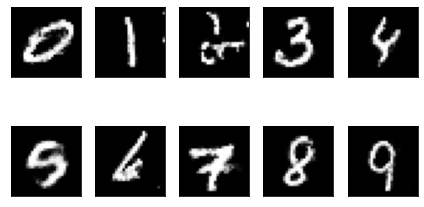

100%|██████████| 468/468 [00:25<00:00, 18.28it/s]


epoch = 94/100, d_loss=0.684, g_loss=0.741                                                                                                     


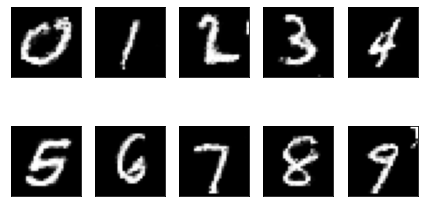

100%|██████████| 468/468 [00:25<00:00, 18.26it/s]


epoch = 95/100, d_loss=0.674, g_loss=0.788                                                                                                     


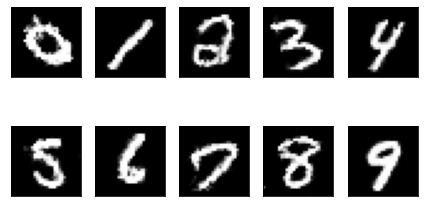

100%|██████████| 468/468 [00:25<00:00, 18.38it/s]


epoch = 96/100, d_loss=0.676, g_loss=0.752                                                                                                     


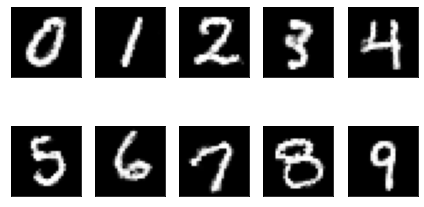

100%|██████████| 468/468 [00:25<00:00, 18.33it/s]


epoch = 97/100, d_loss=0.681, g_loss=0.785                                                                                                     


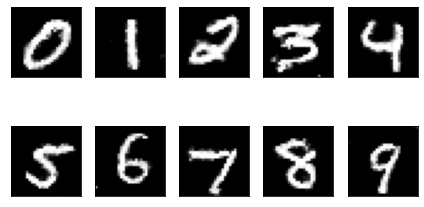

100%|██████████| 468/468 [00:25<00:00, 18.36it/s]


epoch = 98/100, d_loss=0.680, g_loss=0.716                                                                                                     


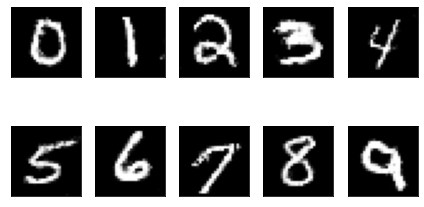

100%|██████████| 468/468 [00:25<00:00, 18.16it/s]


epoch = 99/100, d_loss=0.679, g_loss=0.778                                                                                                     


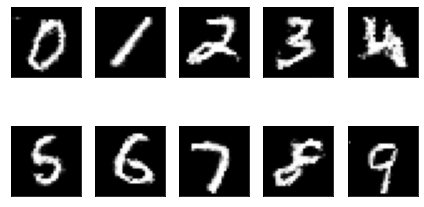

100%|██████████| 468/468 [00:25<00:00, 18.11it/s]


epoch = 100/100, d_loss=0.673, g_loss=0.758                                                                                                     


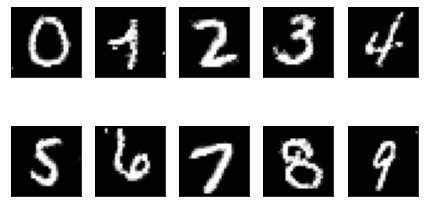

100%|██████████| 468/468 [00:26<00:00, 17.71it/s]


epoch = 101/100, d_loss=0.683, g_loss=0.757                                                                                                     


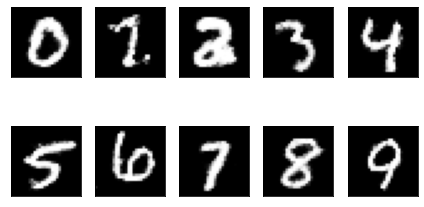

In [22]:
epochs = 100
batch_size = 128
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

# X_train =  X_train[:20000]
for e in range(epochs + 1):
    smooth *= 0.99
    for i in tqdm(range(len(X_train) // batch_size)):
        # Train Discriminator weights
        discriminator.trainable = True
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = gan.train_on_batch(x=[z, random_labels], y=real)
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 1 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        x_fake = generator.predict([z, labels])
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

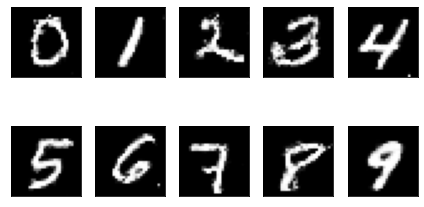

In [23]:
samples = 10

z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
labels = np.arange(0, 10).reshape(-1, 1)
x_fake = generator.predict([z, labels])

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()